# Cancer RNA-Seq Data Clustering
> BingKan Xue, PHZ4710 - Introduction to Biological Physics, University of Florida

In this notebook, we will learn to cluster big data, i.e., to divide the data into distinct groups, so that there is relatively small variation within a group and larger variation between groups. This task belongs to "unsupervised learning", because the training data is not labeled. Compared to classification where our goal is to match the known answers, here we try to find patterns in the data without additional information.

The dataset that we will use as our example is the [gene expression cancer RNA-Seq dataset](https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq). It contains the expression levels of 20531 genes from 801 patients having different types of tumor. Our goal is to analyze the data and cluster them into groups, so that these groups may correspond to different tumor types. The dataset in fact comes with labels --- the patients were diagnosed with 5 types of tumor: BRCA, KIRC, COAD, LUAD and PRAD. But when we analyze the data, we will pretend that the diagnoses are not known (or not all correct?) and see how well we can figure them out.

## Load data

The dataset can be loaded and printed using the `pandas` package, which is a popular data analysis and manipulation package. The data loaded in `pandas` are in the format of `DataFrame`s, and they can be operated by `numpy` just like a normal array (in most cases).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = pd.read_csv('data/cancer/data.csv', header=0, index_col=0)    # load data, using row-0 as column names and column-0 as row names
labels = pd.read_csv('data/cancer/labels.csv', header=0, index_col=0)    # load labels, will use later to check results

In [3]:
data    # print data

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.000000
sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.000000
sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.000000
sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.000000
sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_796,0.0,1.865642,2.718197,7.350099,10.006003,0.0,6.764792,0.496922,0.0,0.0,...,6.088133,9.118313,10.004852,4.484415,9.614701,12.031267,9.813063,10.092770,8.819269,0.000000
sample_797,0.0,3.942955,4.453807,6.346597,10.056868,0.0,7.320331,0.000000,0.0,0.0,...,6.371876,9.623335,9.823921,6.555327,9.064002,11.633422,10.317266,8.745983,9.659081,0.000000
sample_798,0.0,3.249582,3.707492,8.185901,9.504082,0.0,7.536589,1.811101,0.0,0.0,...,5.719386,8.610704,10.485517,3.589763,9.350636,12.180944,10.681194,9.466711,4.677458,0.586693
sample_799,0.0,2.590339,2.787976,7.318624,9.987136,0.0,9.213464,0.000000,0.0,0.0,...,5.785237,8.605387,11.004677,4.745888,9.626383,11.198279,10.335513,10.400581,5.718751,0.000000


In [4]:
labels    # print labels

,Class
sample_0,PRAD
sample_1,LUAD
sample_2,PRAD
sample_3,PRAD
sample_4,BRCA
...,...
sample_796,BRCA
sample_797,LUAD
sample_798,COAD
sample_799,PRAD


Our data is a (801, 20531) array, where each row corresponds to one patient, and each column represents one gene. The values of the entries are non-negative numbers that are readings from the RNA-Seq measurements. We can think of each data point as a 20531-dimensional vector, representing a particular patient that belongs to one of the tumor types. Thus, our goal is to separate the 801 data points into different categories. This may sound like the classification problem we did before, except that here we do not know what are the categories or even how many they are.

## Dimensionality reduction

When dealing with such high-dimensional data, it is a good idea to first reduce the dimensionality, such as by using **Principal Component Analysis (PCA)**. The goal is to find a smaller number of principal components that capture most of the variation among the data points. Imagine that there is one gene that is not expressed in any patient, then this gene (or the dimension it represents) is not useful at all for distinguishing the data points. Therefore we are interested in finding the directions in the data space along which the data points vary the most.

Recall that, to perform PCA, we first calculate the covariance matrix of the data, then find its eigenvectors that correspond to the largest eigenvalues.

In [5]:
N, D = data.shape    # number of data points and dimensions
centered = data - np.mean(data, axis=0)    # subtract the mean
cov = np.dot(centered.T, centered) / N    # calculate the covariance matrix

We can calculate the eigenvalues and eigenvectors using the `numpy.linalg.eigh` function as before. However, this function calculates *all* eigenvalues and eigenvectors, and there are too many (20531) of them here. Since we are interested in only the largest few eigenvalues, we can instead use the `scipy.sparse.linalg.eigs` function (or the `eigsh` function for symmetric matrices) as follows.

In [6]:
import scipy.sparse.linalg as spla

w, v = spla.eigsh(cov, k=50)    # calculate the largest k eigenvalues and their eigenvectors

Here we calculated the largest 50 eigenvalues and their eigenvectors. Recall that each eigenvector represents a principal component (PC), and the corresponding eigenvalue represents the variance along that direction. Let us find the directions with the largest variance and see how many we need to capture most of the total variance. (Note that we need to normalize the eigenvalues by the total variance, which is the sum of all eigenvalues. But because here we did not calculate all eigenvalues, we cannot use the sum of only these eigenvalues. Instead, the total variance can be calculated as the trace of the covariance matrix.)

In [7]:
order = np.argsort(w)[::-1]    # argsort gives ascending order, [::-1] reverses the order
w = w[order]    # order the eigenvalues
v = v[:,order]    # each column is an eigenvector, so we order the columns

wnorm = w / np.trace(cov)    # normalized eigenvalue = fraction of total variance captured
wsum = np.cumsum(wnorm)    # cumulative sum of variance captured

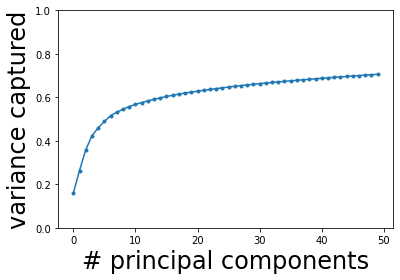

In [8]:
plt.figure()
plt.plot(wsum, '.-')
plt.ylim(0, 1)
plt.xlabel('# principal components', fontsize=24)
plt.ylabel('variance captured', fontsize=24)
plt.show()

We see that the captured fraction of variance increases rapidly with the first few eigenvalues, then slows down and almost plateaus (it will slowly increase to 1 when all 20531 eigenvalues are included). Let us pick, say, $K = 10$ principal components. We will project the original data onto these 10 directions as follows. Note that we will project the mean-subtracted data so that our principal component values will be around 0.

In [9]:
K = 10    # number of principal components to use
PC = v[:,:K]    # use only the first few eigenvectors
projected = np.dot(centered, PC)    # project centered data points onto principal directions

We can try to visualize these principal components, although it is hard to make plots in more than 2 or 3 dimensions. Since the first few components capture the most variance, we could hope that plotting 2 or 3 of them would be enough. It turns out that the first and third PCs give a pretty good impression of the data.

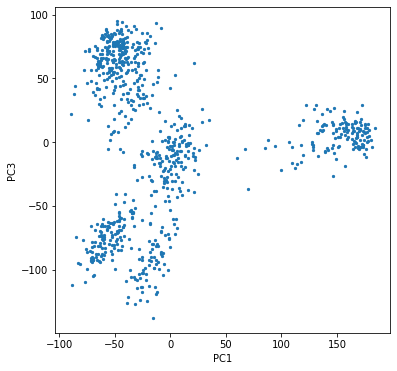

In [10]:
plt.figure(figsize=(6,6))
plt.scatter(projected[:,0], projected[:,2], s=5)
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.show()

We see that the data points are naturally separated into 5 clusters. To improve visualization, we can color the data points according to their labels (which we have pretended not to know). For that we need a bit of processing of the labels since they were given as strings but we want indices.

In [11]:
types = set(labels['Class'])    # collect all tumor types
nt = len(types)    # number of types
print(types)

{'COAD', 'LUAD', 'PRAD', 'BRCA', 'KIRC'}


In [12]:
type_to_index = dict(zip(types, range(nt)))    # map string labels to indices
indices = labels['Class'].map(type_to_index).to_numpy()    # convert labels to indices for all data points

We can now plot the data points in 3D with colors.

In [13]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation as anim
plt.rcParams["animation.html"] = "jshtml"
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = np.asarray(cycle)[indices]

fig = plt.figure(figsize=(8,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(projection="3d")
ax.scatter(projected[:,0], projected[:,1], projected[:,2], s=5, c=colors)
ax.set_xlabel(r'PC1')
ax.set_ylabel(r'PC2')
ax.set_zlabel(r'PC3')
fig.set_facecolor('w')

def animate(i):
    ax.view_init(elev=10., azim=i*10)
    return fig,

mov = anim.FuncAnimation(fig, animate, frames=36)
# mov.save('figures/cancer.gif', fps=5)
plt.close()

In [14]:
mov

We see that the clusters match very well with the colors. It shows that the first few principal components successfully capture the main features of the dataset. Therefore, we will use these principal components to cluster the data points, again pretending that we do not know the labels (colors).

## Clustering

Our goal is to separate the data points into multiple clusters according to their relative positions in the data space (or the reduced low-dimensional space). We would like the data points within the same cluster to be close together, and different clusters to be relatively far apart. The number of clusters needed to separate the data points is often not known beforehand, so finding the appropriate number of clusters is part of the task. In simple clustering algorithms, such as **k-means** that we will use, the number of clusters is chosen by hand and given to the algorithm. More sophisticated algorithms may select this number automatically according to certain criteria.

The k-means algorithm aims at minimizing the mean squared distance between all pairs of data points within the same cluster, i.e.,
\begin{equation}
L = \sum_{i=1}^k \frac{1}{2 N_i} \sum_{\mathbf{X}_n, \mathbf{X}_m \in S_i} \big| \mathbf{X}_n - \mathbf{X}_m \big|^2
\end{equation}
where $S_i$ is the set of data points belonging to the $i$-th cluster for $i = 1, \cdots, k$, and $N_i$ is the number of data points in $S_i$. Each data point $\mathbf{X}_n$ is a vector in the data space, and $|\mathbf{X}_n - \mathbf{X}_m|$ is the Euclidean distrance between two such points. This cost function can be equivalently expressed as the sum of squared distance from every data point to the center of its own cluster, i.e.,
\begin{equation}
L = \sum_{i=1}^k \sum_{\mathbf{X}_n \in S_i} \big| \mathbf{X}_n - \mathbf{\mu}_i \big|^2, \qquad \textsf{where} \quad \mathbf{\mu}_i = \frac{1}{N_i} \sum_{\mathbf{X}_n \in S_i} \mathbf{X}_n
\end{equation}
This minimization problem is not easy in the sense that the global minimum is hard to find. However, the k-means algorithm quickly converges to a local minimum, which may be good enough.

The algorithm requires the number of clusters, $k$, as an input. One may also provide initial guesses for the center positions of every cluster. If not given, the algorithm will use random initial positions for the cluster centers. Because of this randomness and the fact that it only finds the local minimum, running the algorithm twice may give different results. So you may have to try a few times and check if the clustering result is satisfactory.

The heuristic idea behind the algorithm is to iterate over two simple steps. The first step starts with the current guess for the center position of every cluster, and reassigns all data points to their nearest center. The second step then collects the data points now assigned to each cluster, and recalculates their center position. The algorithm alternates between these two steps until no reassignment happens, which means the result has converged.

Luckily, we don't have to program this algorithm ourselves, since it is already provided by the python function `scipy.cluster.vq.kmeans2`. In the following, we will use this function to cluster our data. We will use the dimensionally reduced data that we got from PCA above. Also, since we saw that the data points seem to separate nicely into 5 clusters (in agreement with the 5 diagnosed tumor types, which we pretend not to know), we will ask the algorithm to find k = 5 clusters.

In [15]:
import scipy.cluster.vq as vq

k = 5    # choose number of clusters
centroid, lab = vq.kmeans2(projected, k)    # perform k-means algorithm

The two outputs are: `centroid`, which is a 2-d array where each row represents the center of a cluster, and `lab`, which is a 1-d array where each entry is an index telling us which cluster each data point belongs to. We could use the `lab` indices to color our data points and plot the clustering result. (Note that the clusters are randomly ordered by `k-means`. We can reorder them to match the "true labels" we saw above.)

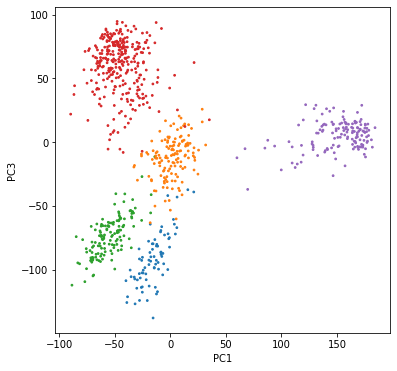

In [16]:
colormap = []
for cent in centroid:
    med = np.argmin(np.sum((projected - cent)**2, axis=1))   # find a point close to each center
    colormap.append(indices[med])    # find the true label for that point and use its index for the cluster
newindices = np.asarray(colormap)[lab]    # convert to new indices for all points
newcolors = np.asarray(cycle)[newindices]    # reorder labels

plt.figure(figsize=(6,6))
plt.scatter(projected[:,0], projected[:,2], s=3, c=newcolors)
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.show()

We see that the colors match very well with the clusters. You may notice some points that seem to wander into another cluster --- that is because we are only plotting two dimensions, and the points that look overlapping may very well be separated in some other dimensions. Try plotting some other principal components yourself.

Finally, let us see how well we have clustered the data compared to the true labels. Let us highlight the points that are wrongly clustered.

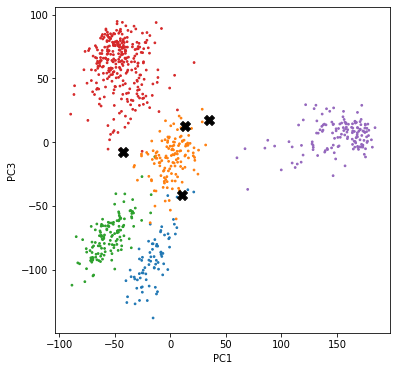

In [17]:
wrong = (newindices != indices)

plt.figure(figsize=(6,6))
plt.scatter(projected[:,0], projected[:,2], s=3, c=newcolors)
plt.scatter(projected[wrong,0], projected[wrong,2], s=100, c='k', marker='X')
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.show()

It turns out that we only made 4 mistakes out of 801 data points. Also, it can be seen that the wrongly clustered data points lie near the boundary of the clusters, which makes the mistakes quite understandable.